In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import itertools

In [3]:
from ecephys_analyses.psth import make_psth_figures
from ecephys_analyses.data import paths

In [4]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# All

In [18]:
OUTPUT_DIR = None  # If None, save all the plots in root_dir/subject/condition/plots/sorting_condition

root_key = 'eStim'  # A key in `ecephys_analyses/data/conditions.yml` specifying the path where we save all subjects' data

#### Data params

subject = 'Eugene'  # Short name. The long name should be specified in `ecephys_analyses/data/channel_groups.py`

condition_group = 'eStim'  # eg 'eStim'. A key in `ecephys_analyses/data/conditions.yml` specifying the list of conditions to process

sorting_condition = 'ks2_5_catgt_df_postpro_1' # Name of the curated kilosort output directory

good_only_values = [
    False,
]  # Use only units labeled as 'good' after curation

states = [
    "NREM", "Wake", "N2", "REM",
]  # States to compute. The `stim_times.csv` file should have a `stim_state` column

regions = [
    'cortex',
    'thalamus',
    'all',
]  # Regions to compute. if not 'all', should be a key in `ecephys_analyses/data/regions.yml`

selection_intervals = {
    'fr': (0.0, float('inf'))
    # etc, etc, Keys are columns from cluster_info.tsv or metrics.csv.
}
selection_intervals = None

conditions = paths.get_conditions(subject, condition_group)
print(f"N={len(conditions)} conditions: {conditions}")

#### PSTH params

norm_window = [-10000, 2000]  # Window for computing and normalizing PSTH. [norm_window[0], 0] is used as baseline to normalize the PSTH
# norm_window = [-4000, 2000]  # For Allan only since the pulses
plot_window = [-500, 500]  # Window for plotting the PSTH. (Can be shorter than window for normalization)
binsize = 10  # To bin spikes

#### Plot

clim_values = [
    [-3, 3],
]  # Color scale domain for z-scored data
draw_region_limits = True  # Draw region on plot

#### Run

n_jobs = 10  # How many jobs in parallel

N=13 conditions: ['10-9-2020_NREM_depth1.5_imec0', '10-19-2020_NREM_depth1.5_imec0', '10-2-2020_NREM_depth1.4_imec0', '10-9-2020_NREM_depth1.2_imec0', '10-2-2020_NREM_depth1.1_imec0', '10-9-2020_NREM_depth0.9_imec0', '10-2-2020_NREM_depth0.8_imec0', '10-19-2020_REM_depth1.5_imec0', '10-2-2020_Wake_depth1.5_imec0', '10-9-2020_Wake_depth1.4_imec0', '10-2-2020_Wake_depth1.2_imec0', '10-9-2020_Wake_depth1.1_imec0', '10-9-2020_Wake_depth0.8_imec0']


In [19]:
print(conditions)

['10-9-2020_NREM_depth1.5_imec0', '10-19-2020_NREM_depth1.5_imec0', '10-2-2020_NREM_depth1.4_imec0', '10-9-2020_NREM_depth1.2_imec0', '10-2-2020_NREM_depth1.1_imec0', '10-9-2020_NREM_depth0.9_imec0', '10-2-2020_NREM_depth0.8_imec0', '10-19-2020_REM_depth1.5_imec0', '10-2-2020_Wake_depth1.5_imec0', '10-9-2020_Wake_depth1.4_imec0', '10-2-2020_Wake_depth1.2_imec0', '10-9-2020_Wake_depth1.1_imec0', '10-9-2020_Wake_depth0.8_imec0']


In [20]:
print(selection_intervals)

None




Generate figures for Eugene 10-9-2020_NREM_depth1.5_imec0, NREM, cortex, good=False, clim=[-3, 3], output=/Volumes/neuropixel_analysis/Data/tom/catgt/CNPIX6-Eugene/10-9-2020_NREM_depth1.5_imec0/plots/ks2_5_catgt_df_postpro_1
Get all psth, window=[-10000, 2000], binsize=15
Get sorting extractor, region=cortex, selection_intervals={}, good_only=False, root_key=eStim
N clusters (all)=370
Subset clusters: good_only=False, drop_noise=True, selection_intervals={'depth': [6260, 7660]}
 -> Drop N=33/370 noise clusters
 -> Info column = `depth`: Drop N=351/370 not within interval = `[6260, 7660]
Subselect N = 7/370 clustersLoad events at /Volumes/neuropixel_analysis/Data/tom/catgt/CNPIX6-Eugene/10-9-2020_NREM_depth1.5_imec0/stim_times.csv
N events = 91
Done getting psth data
Zscore by baseline
666
Surface depth 7660
Done getting plot


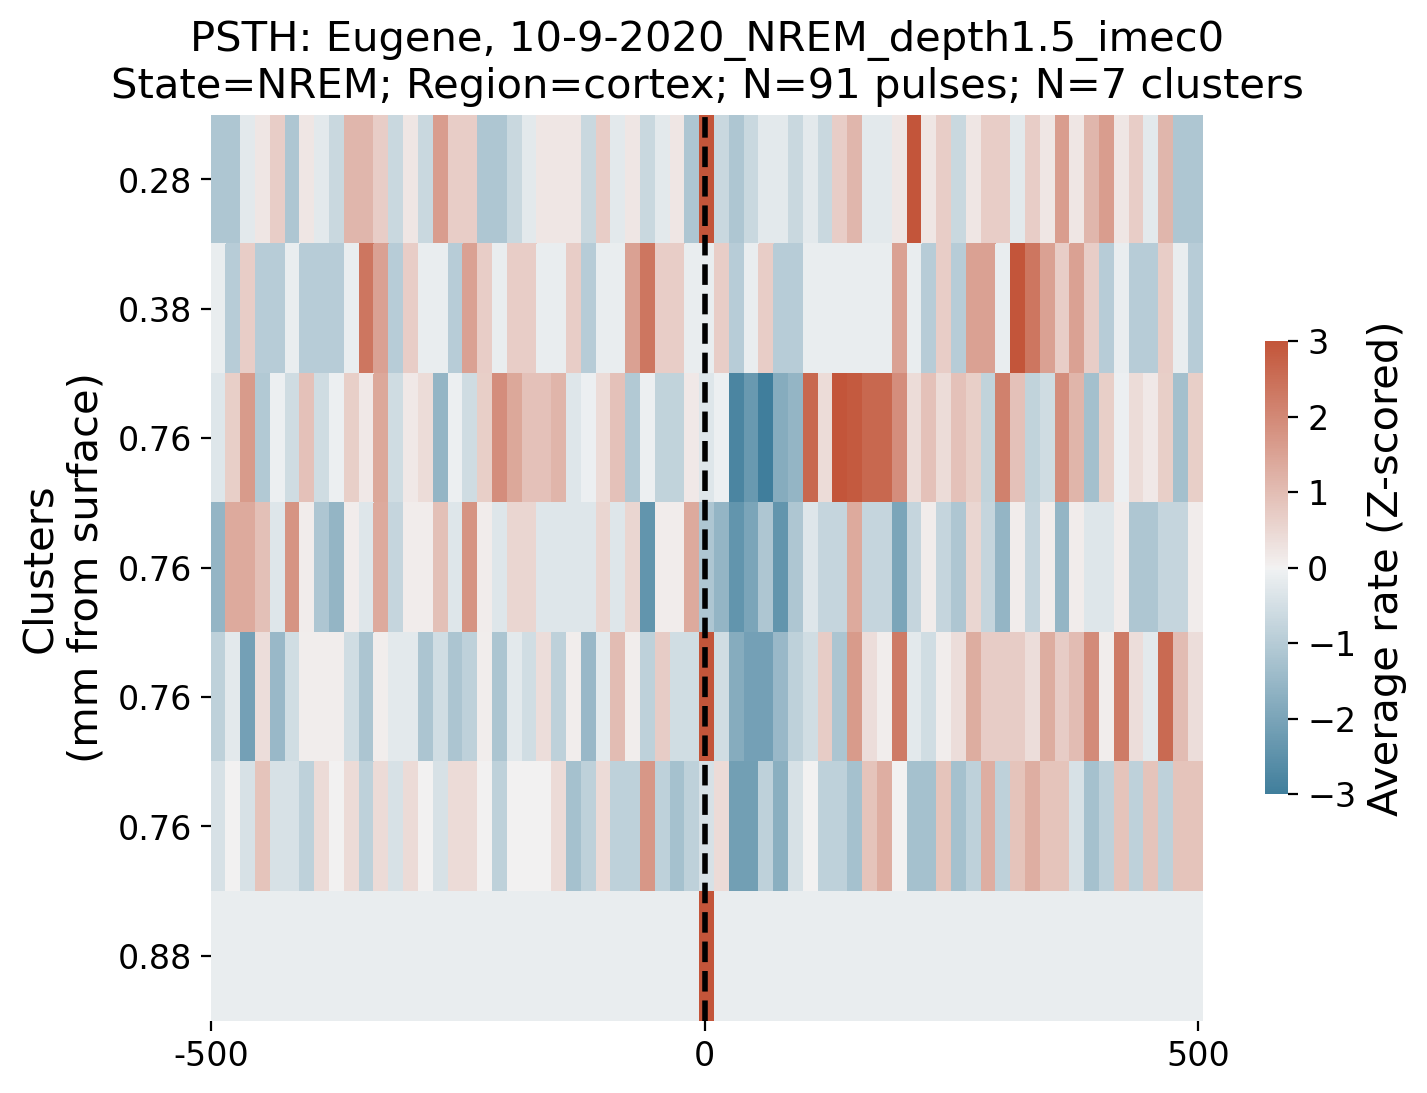

In [21]:
# Example fig..
fig, ax = make_psth_figures(
    subject, conditions[0], sorting_condition,
    good_only=good_only_values[0],
    normalize='baseline_zscore',
    region=regions[0],
    selection_intervals=selection_intervals,
    norm_window=norm_window,
    plot_window=plot_window,
    state=states[0], clim=clim_values[0],
    root_key=root_key,
    save=False, show=True,
    output_dir=None, draw_region_limits=True
)

In [ ]:
if n_jobs == 1:
    for (
            condition,
            state,
            region, 
            good_only,
            clim
    ) in itertools.product(
        conditions, states, regions, good_only_values, clim_values
    ):
        make_psth_figures(
            subject,
            condition,
            sorting_condition,
            state=state,
            region=region,
            good_only=good_only,
            selection_intervals=selection_intervals,
            binsize=binsize,
            norm_window=norm_window,
            plot_window=plot_window,
            clim=clim,
            save=True,
            show=False,
            draw_region_limits=draw_region_limits,
            output_dir=OUTPUT_DIR,
        )
else:
    from joblib import Parallel, delayed
    
    def make_figures_parall( condition, state, region,  good_only, clim ):
        make_psth_figures(
            subject,
            condition,
            sorting_condition,
            state=state,
            region=region,
            good_only=good_only,
            selection_intervals=selection_intervals,
            binsize=binsize,
            norm_window=norm_window,
            plot_window=plot_window,
            clim=clim,
            save=True,
            show=False,
            draw_region_limits=draw_region_limits,
            output_dir=OUTPUT_DIR,
        )
#         try:
#             make_psth_figures(
#                 subject,
#                 condition,
#                 sorting_condition,
#                 state=state,
#                 region=region,
#                 good_only=good_only,
#                 binsize=binsize,
#                 norm_window=norm_window,
#                 plot_window=plot_window,
#                 clim=clim,
#                 save=True,
#                 show=False,
#                 draw_region_limits=draw_region_limits,
#                 output_dir=OUTPUT_DIR,
#             )
#         except Exception as e:
#             print(f"failed :", subject, condition, state, region,  good_only, clim)
#             print(repr(e))
#             raise e
        
    Parallel(n_jobs=n_jobs, backend='multiprocessing')(
        delayed(make_figures_parall)(
            condition,
            state,
            region, 
            good_only,
            clim
        ) for (
            condition,
            state,
            region, 
            good_only,
            clim
        ) in itertools.product(
            conditions, states,
            regions, good_only_values, clim_values
        )
    )
    print('done')